In [1]:
%run -m cytokit_nb.logging
%matplotlib inline
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import cytokit.io as cytokit_io
import cytokit.config as cytokit_config
import cytokit.function.data as cytokit_data
from cytokit.ops import cytometry
from skimage import io as skimage_io
from skimage import exposure
from skimage import filters

exp_name = '20181116-d41-r1-20x-5by5'
output_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'cytokit', 'cellular-marker', exp_name, 'output', 'v00')

In [2]:
ireg, tx, ty = 0, 0, 0
config = cytokit_config.load(osp.join(output_dir, 'config'))
z = cytokit_data.get_best_focus_coord_map(output_dir)[(ireg, tx, ty)]
tile = cytokit_io.read_tile(osp.join(output_dir, cytokit_io.get_processor_img_path(ireg, tx, ty)))
tile.shape, z

((1, 25, 4, 1008, 1344), 13)

In [3]:
def get_ch_image(ch):
    icyc, ich = config.get_channel_coordinates(ch)
    return tile[icyc, z, ich]
get_ch_image('DAPI').shape

(1008, 1344)

In [4]:
def get_segmentation(config_fn):
    c = cytokit_config.load(osp.join(output_dir, 'config'))
    c = config_fn(c)
    op = cytometry.Cytometry2D(c).initialize()
    return op.run(tile, best_focus_z_plane=z)

In [3]:
config._conf['processor']['cytometry']['segmentation_params']

{'memb_hole_size': 48,
 'memb_max_dist': None,
 'memb_min_dist': 3,
 'memb_propagation_regularization': 0.25,
 'memb_sigma': 2}

In [10]:
def modify(c):
    c._conf['processor']['cytometry']['segmentation_params']['memb_sigma'] = 2
    c._conf['processor']['cytometry']['segmentation_params']['memb_hole_size'] = 48
    c._conf['processor']['cytometry']['segmentation_params']['memb_propagation_regularization'] = .25
    c._conf['processor']['cytometry']['segmentation_params']['memb_min_dist'] = 3
    c._conf['processor']['cytometry']['segmentation_params']['memb_max_dist'] = None
    return c

In [11]:
img_label, _ = get_segmentation(modify)
img_label.shape

(2, 25, 2, 1008, 1344)

In [12]:
img_bound = (img_label[1, z, 0] > 0) * 255
img_nuc = (img_label[0, z, 1] > 0) * 255

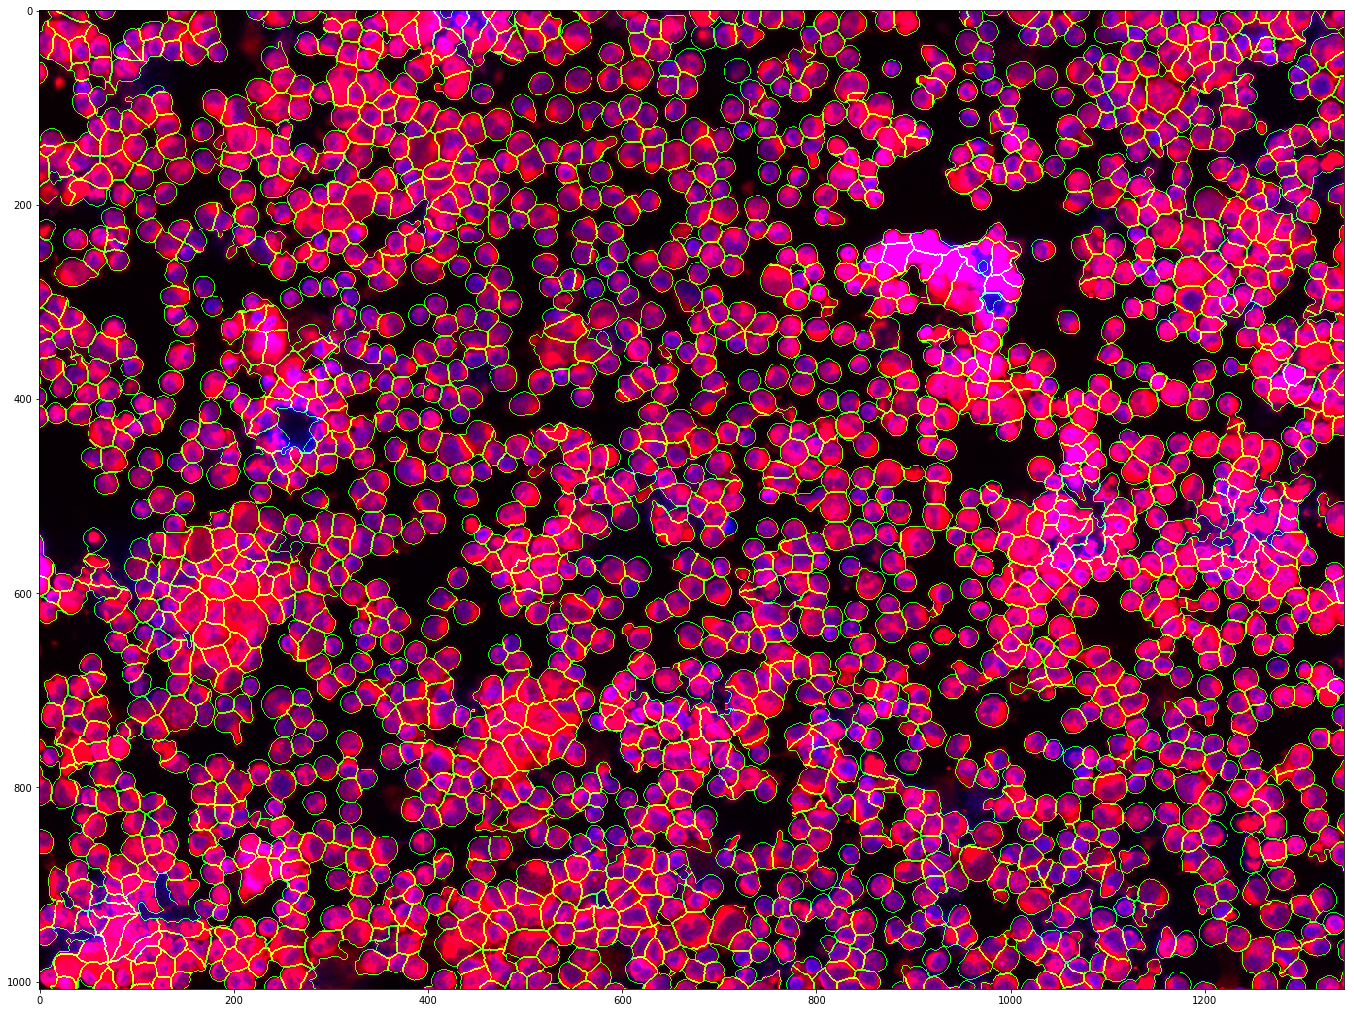

In [14]:
def clip(img, maxv):
    return exposure.rescale_intensity(img.clip(0, maxv), out_range=str(img.dtype)).astype(img.dtype)

def get_pha_mask():
    img = get_ch_image('PHA')
    img = filters.gaussian(img, sigma=3)
    thresh = filters.threshold_li(img)
    return ((img > thresh) * 255).astype(np.uint8)

img_pha = get_ch_image('PHA')
imgs = [
    clip(get_ch_image('PHA'), 100),
#     get_pha_mask(),
    img_bound,
    clip(get_ch_image('DAPI'), 150)
]
# imgs = [
#     get_pha_mask(),
#     img_bound,
#     img_nuc
# ]

res = np.stack(imgs, axis=-1).astype(np.uint8)
skimage_io.imsave('/lab/data/tmp/cells.png', res)
plt.imshow(res)
plt.gcf().set_size_inches(24, 18)